In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub
import tensorflow_text as text

In [3]:
train_path = './Datasets/SNIPS/train/'
val_path = './Datasets/SNIPS/valid/'
test_path = './Datasets/SNIPS/test/'

In [4]:
def read_data(file_path):
    with open(file_path) as files:
        file = [i.strip() for i in files]
    return file

In [5]:
train_x = read_data(train_path+'seq.in')
train_y = read_data(train_path+'label')

val_x = read_data(val_path+'seq.in')
val_y = read_data(val_path+'label')

test_x = read_data(test_path+'seq.in')
test_y = read_data(test_path+'label')

print("No. of training samples: ",len(train_x))
print("No. of validation samples: ", len(val_x))
print("No. of test samples ",len(test_x))

print("\nTotal number of intents: ",np.shape(np.unique(np.array(train_y)))[0])

No. of training samples:  13084
No. of validation samples:  700
No. of test samples  700

Total number of intents:  7


In [6]:
labels, label_count = np.unique(np.array(train_y),return_counts=True)

pd.DataFrame(list(zip(labels,label_count)),columns=['label','label_count'])

,label,label_count
0,AddToPlaylist,1818
1,BookRestaurant,1881
2,GetWeather,1896
3,PlayMusic,1914
4,RateBook,1876
5,SearchCreativeWork,1847
6,SearchScreeningEvent,1852


In [7]:
print("Sample dataset:")
print(train_x[1], train_y[1])
print(train_x[200], train_y[200])
print(train_x[300], train_y[300])
print(train_x[500], train_y[500])
print(train_x[800], train_y[800])
print(train_x[1300], train_y[1300])

Sample dataset:
add step to me to the 50 clásicos playlist AddToPlaylist
find the show go with the flow SearchCreativeWork
search for the toucher and rich show SearchCreativeWork
add billy strayhorn to my highway 61 playlist AddToPlaylist
play music by paul mccartney PlayMusic
give zero out of 6 points to marxism and the oppression of women RateBook


In [8]:
max_seq_length = max([len(x) for x in train_x])
classes = np.unique(train_y).tolist()

In [9]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-10-11 21:24:06.815784: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [10]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

x = tf.keras.layers.Dense(128,activation='relu')(outputs['pooled_output'])
x = tf.keras.layers.Dense(64,activation='relu')(x)
x = tf.keras.layers.Dense(len(classes),activation='softmax')(x)

model = tf.keras.Model(inputs=[text_input], outputs = [x])

In [11]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 

def precision(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 

def f1_score(y_true, y_pred):    
    
    p_recision = precision(y_true, y_pred), 
    r_call= recall(y_true, y_pred)
    
    return 2*((p_recision*r_call)/(p_recision+r_call+K.epsilon()))

In [12]:
model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=[tf.metrics.CategoricalAccuracy(),precision,recall,f1_score])

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [14]:
train_x = np.asarray(train_x)
val_x = np.asarray(val_x)

train_y_numerical = [classes.index(x) for x in train_y]# tf.keras.utils.to_categorical([classes.index(x) for x in train_y])
val_y_numerical = [classes.index(x) for x in val_y] 

train_y_categorical = tf.keras.utils.to_categorical(train_y_numerical)
val_y_categorical = tf.keras.utils.to_categorical(val_y_numerical)

In [15]:
history = model.fit(train_x,train_y_categorical,
                    epochs=5,
                    validation_data=(val_x,val_y_categorical))

Epoch 1/5
409/409 [==============================] - 901s 2s/step - loss: 1.0076 - categorical_accuracy: 0.6555 - precision: 0.5827 - recall: 0.4273 - f1_score: 1.5129 - val_loss: 0.5313 - val_categorical_accuracy: 0.8400 - val_precision: 0.1806 - val_recall: 0.1349 - val_f1_score: 0.3248
Epoch 2/5
409/409 [==============================] - 887s 2s/step - loss: 0.4034 - categorical_accuracy: 0.8641 - precision: 0.8952 - recall: 0.8122 - f1_score: 3.0872 - val_loss: 0.4201 - val_categorical_accuracy: 0.8529 - val_precision: 0.1779 - val_recall: 0.1469 - val_f1_score: 0.3525
Epoch 3/5
409/409 [==============================] - 897s 2s/step - loss: 0.2995 - categorical_accuracy: 0.8956 - precision: 0.9127 - recall: 0.8622 - f1_score: 3.3049 - val_loss: 0.3657 - val_categorical_accuracy: 0.8814 - val_precision: 0.1813 - val_recall: 0.1542 - val_f1_score: 0.3719
Epoch 4/5
409/409 [==============================] - 897s 2s/step - loss: 0.2637 - categorical_accuracy: 0.9074 - precision: 0.916

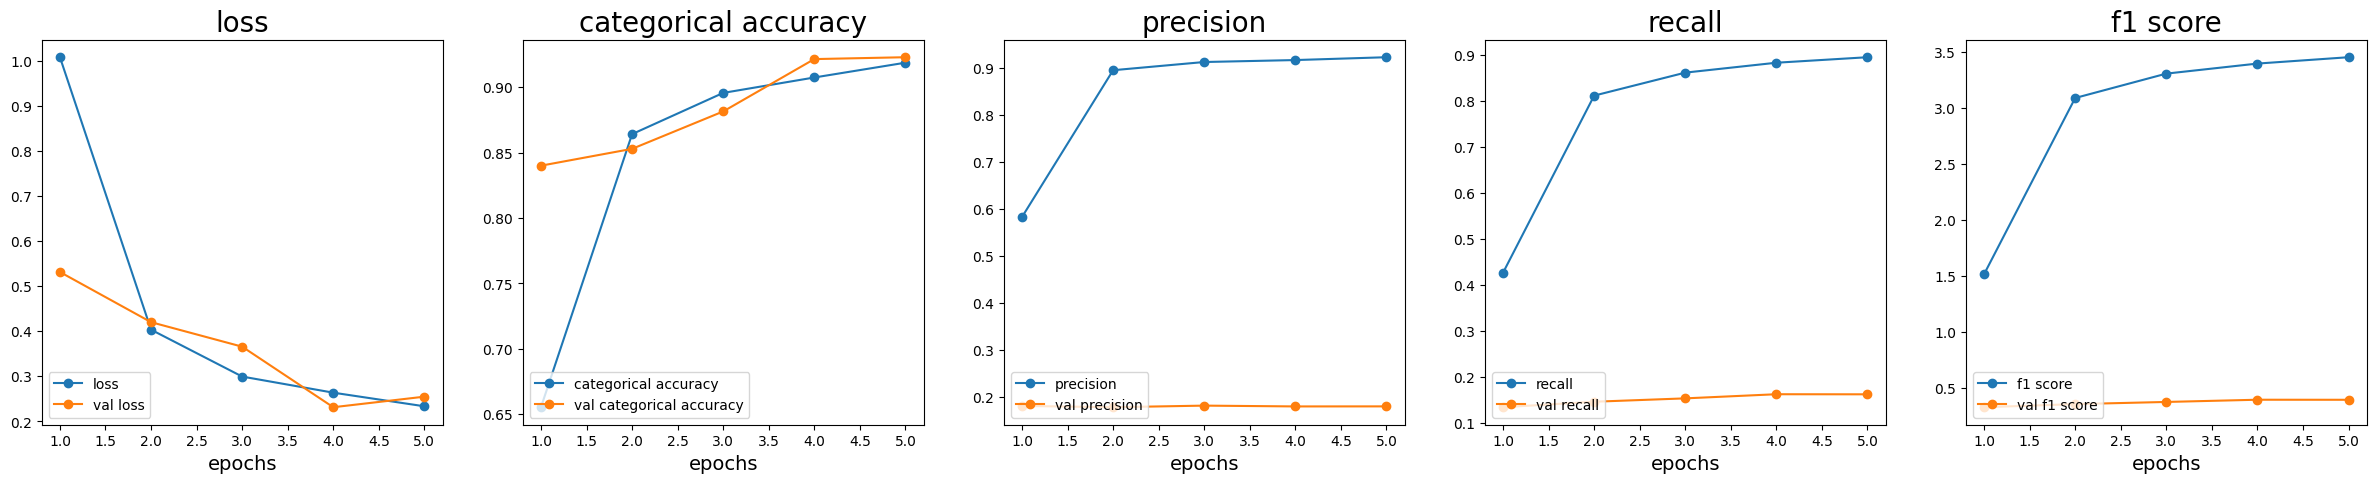

In [19]:
x = list(range(1, 5+1))
metric_list = list(history.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
  ax[i].plot(x, history.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
  ax[i].plot(x, history.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
  ax[i].set_xlabel("epochs",fontsize=14)
  ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
  ax[i].legend(loc="lower left")

In [1]:
model.save('bert_intent_classification.h5')

NameError: name 'model' is not defined